# Analysis

Import libraries

In [1]:
import pandas as pd
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import scipy.stats as stats
from scipy.stats import shapiro
import seaborn as sns
import re
import matplotlib.patches as mpatches

### Functions - Preprocessing

BASICS

In [2]:
def add_time_column(df):
    df = df.copy() 
    # Check if 'gaze_capture_time' is integer type before conversion
    if pd.api.types.is_integer_dtype(df['gaze_capture_time']):
        df.loc[:, 'time'] = (pd.to_datetime(df['gaze_capture_time']) - pd.to_datetime(df['gaze_capture_time'].iloc[0])).dt.total_seconds()
    else:
        df.loc[:, 'gaze_capture_time'] = pd.to_datetime(df['gaze_capture_time'])
        df.loc[:, 'time'] = (df['gaze_capture_time'] - df['gaze_capture_time'].iloc[0]).dt.total_seconds()
    return df

def add_blink_column(df):
    df = df.copy()
    df.loc[:, 'blink'] = (df['left_pupil_diameter'] == 0) | (df['right_pupil_diameter'] == 0)
    return df

def select_relevant_columns(df):
    columns_to_keep = ['time', 'left_pupil_diameter', 'right_pupil_diameter', 'is_building_model', 'model_name', 'blink']
    df = df.copy()
    return df[columns_to_keep]

HANDLING BLINKS AND UNREALISTIC OUTLIERS

In [3]:
def add_combined_buffer(df, blink_col='blink', lower=2, upper=8, buffer=30):
    # Blink mask
    blink_mask = df[blink_col].values
    
    # Outlier mask: true where pupil diameter outside normal range
    outlier_mask = ((df['left_pupil_diameter'] < lower) | (df['left_pupil_diameter'] > upper) |
                    (df['right_pupil_diameter'] < lower) | (df['right_pupil_diameter'] > upper)).values
    
    # Combine both masks
    combined_mask = blink_mask | outlier_mask
    
    # Initialize expanded mask
    expanded_mask = np.zeros(len(combined_mask), dtype=bool)
    
    # Buffer around each problematic index
    indices = np.where(combined_mask)[0]
    for idx in indices:
        start = max(0, idx - buffer)
        end = min(len(combined_mask), idx + buffer + 1)
        expanded_mask[start:end] = True
    
    return expanded_mask

def remove_outliers(df, lower=2, upper=8):
    df = df.copy()
    df.loc[(df['left_pupil_diameter'] < lower) | (df['left_pupil_diameter'] > upper), 'left_pupil_diameter'] = np.nan
    df.loc[(df['right_pupil_diameter'] < lower) | (df['right_pupil_diameter'] > upper), 'right_pupil_diameter'] = np.nan
    return df

def interpolate_missing(df):
    # interpolate NaNs in pupil diameter columns
    df = df.copy()
    df.loc[:, 'left_pupil_diameter'] = df['left_pupil_diameter'].interpolate(method='linear', limit_direction='both')
    df.loc[:, 'right_pupil_diameter'] = df['right_pupil_diameter'].interpolate(method='linear', limit_direction='both')
    return df

def preprocess_blinks(df, blink_col='blink', lower=2, upper=8, buffer=30):
    df = df.copy()
    buffered_mask = add_combined_buffer(df, blink_col=blink_col, lower=lower, upper=upper, buffer=buffer)
    
    df.loc[buffered_mask, ['left_pupil_diameter', 'right_pupil_diameter']] = np.nan
    
    df = interpolate_missing(df)
    
    return df

# Get mean pupil diameter
def add_mean_pupil_diameter(df):
    df = df.copy()
    df['mean_pupil_diameter'] = df[['left_pupil_diameter', 'right_pupil_diameter']].mean(axis=1)
    return df

FINAL PREPROCESSING FUNCTION

In [4]:
def preprocess(df, buffer_samples):
    df = add_time_column(df)
    df = add_blink_column(df)
    df = select_relevant_columns(df)
    df = remove_outliers(df) # removes and interpolates over values <2mm and >8mm
    df = preprocess_blinks(df, blink_col='blink', buffer=buffer_samples) # calls the blink mask and interpolation functions
    df = add_mean_pupil_diameter(df)
    return df

### Functions - Summarizing

CREATING df FOR FURTHER ANALYSIS

In [5]:
# Extract participant number (UID)
def extract_uid(csv_path):
    filename = os.path.basename(csv_path)
    filename_no_ext = os.path.splitext(filename)[0]
    return filename_no_ext[:2]

# Identify continuous 'True' blocks in is_building_model
def identify_model_blocks(df):
    df = df.copy()
    df['block_id'] = (df['is_building_model'] != df['is_building_model'].shift()).cumsum()
    model_blocks = df[df['is_building_model']].groupby('block_id')
    return df, model_blocks

# Extract blink count
def count_blinks(blink_series):
    shifted = blink_series.shift(1, fill_value=False)
    blink_starts = (blink_series == True) & (shifted == False)
    return blink_starts.sum()

# Calculate blink rate (blinks/minute - baseline of 20 blinks/minute (Magliacano et al, 2020))
def calculate_blink_rate(block_df, baseline=20):

    # Ensure time is sorted ascending
    block_df = block_df.sort_values('time').copy()

    # Define start time
    start_time = block_df['time'].iloc[0]

    # Create minute bins (floor to nearest minute)
    block_df['minute_bin'] = ((block_df['time'] - start_time) // 60).astype(int)

    # Count blink onsets per minute
    def count_blinks(blink_series):
        shifted = blink_series.shift(1, fill_value=False)
        blink_starts = (blink_series == True) & (shifted == False)
        return blink_starts.sum()

    per_minute_blinks = block_df.groupby('minute_bin')['blink'].apply(count_blinks)

    # Difference from baseline per minute
    per_minute_diff = per_minute_blinks - baseline

    # Sum differences across block
    return per_minute_diff.sum()

def summarize_blocks(model_blocks, UID):
    included_blocks = []
    summary_list = []

    # Filter out blocks with model_name == 'TM'
    for block_id, block_df in model_blocks:
        model_name = block_df['model_name'].iloc[0]
        if model_name == 'TM':
            continue
        included_blocks.append((block_id, block_df))

    # Assign conditions and compute stats
    for i, (block_id, block_df) in enumerate(included_blocks):
        
        # Assign conditions to blocks
        model_name = block_df['model_name'].iloc[0]
        start_time = block_df['time'].iloc[0]
        end_time = block_df['time'].iloc[-1]
        trial_duration = end_time - start_time
        avg_pupil = block_df['mean_pupil_diameter'].mean()
        
        # Extract last character of model_name to determine familiarity
        last_char = model_name[-1].lower()
        familiarity = 'abstract' if last_char == 'a' else ('familiar' if last_char == 'f' else 'unknown')
        
        # Count blinks in this block
        blink_count = count_blinks(block_df['blink'])
        
        # Calculate blink_rate
        blink_rate = calculate_blink_rate(block_df, baseline=20)
        
        # Determine condition based on position (i: 0-based)
        condition = 1 if i < 6 else (2 if i < 12 else 3)
        
        # Extract complexity from first two characters of model_name
        complexity_code = model_name[:2].upper()
        complexity = {'C1': 'easy', 'C2': 'moderate', 'C3': 'hard'}.get(complexity_code, 'unknown')
        
        # Add model_number column by cycling through 1 to 6 for each group of 6 models
        model_number = (i % 6) + 1

        summary_list.append({
            'UID': UID,
            'block_id': block_id,
            'condition': condition,
            'model_number': model_number,
            'model_name': model_name,
            'complexity': complexity,
            'mean_pupil_diameter_in_mm': avg_pupil,
            'trial_duration_in_sec': trial_duration,
            'familiarity': familiarity,
            'blink_count': blink_count,
            'blink_rate': blink_rate
        })

    return pd.DataFrame(summary_list)

ADDING QUESTIONNAIRE DATA

In [6]:
# Read all condition CSVs for a participant and question type, combine into a single DataFrame with UID, condition, and model_number columns.
def read_questionnaire_data(data_folder, participant_id, question_type):
    dfs = []
    for condition_num in range(1, 4):
        pattern = f"{participant_id}_{question_type}_Condition{condition_num}_*.csv"
        csv_paths = glob.glob(os.path.join(data_folder, pattern))
        if not csv_paths:
            continue  # no file for this participant and condition

        csv_path = csv_paths[0]
        df = pd.read_csv(csv_path).copy()
        
        # Exclude training model (ItemNumber == 1)
        df = df[df['ItemNumber'] != 1]
        
        # Adjust ItemNumber to zero-based model_number for matching summary data
        df['model_number'] = df['ItemNumber'] - 1
        
        # Add participant and condition columns for merging
        df['UID'] = participant_id
        df['condition'] = condition_num
        
        dfs.append(df)

    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        return pd.DataFrame()  # empty df if no files found

## Actual Code

Create the summary data frame

In [7]:
buffer_samples = 30 # adjust as needed (10-30, correspond to 50-150ms)

data_folder = 'D:/PilotData'  # Folder where your CSV files are located

questionnaire_folder = 'D:/PilotData/InGameQuestions'  # Folder with questionnaire CSVs

# Get list of all CSV files
csv_files = glob.glob(os.path.join(data_folder, '*.csv'))

# Get unique sorted participants dynamically
participant_ids = sorted(set(extract_uid(f) for f in csv_files), key=int)

all_summaries = []
all_clean_dfs = [] 

# Iterate over sorted participants
for pid in participant_ids:
    # Find all files for current participant
    pattern = os.path.join(data_folder, f"{pid}_*.csv")
    participant_files = sorted(glob.glob(pattern))  # sort files per participant if multiple
    
    print(f"Processing participant {pid} with files: {participant_files}")
    
    for csv_path in participant_files:
        # Load raw data for one participant
        df_raw = pd.read_csv(csv_path, dtype={'model_name': str})
        # Remove rows where the model_name column is NaN
        df_raw = df_raw.dropna(subset=['model_name'])

        # Extract participant ID from filename
        UID = extract_uid(csv_path)

        # Preprocess the raw data
        clean_df = preprocess(df_raw, buffer_samples=buffer_samples)
        clean_df['UID'] = UID

        # Identify model blocks
        clean_df, model_blocks = identify_model_blocks(clean_df)

        # Summarize metrics per model building block
        summary_df = summarize_blocks(model_blocks, UID)

        # Collect this participant’s summary
        all_summaries.append(summary_df)
        
        all_clean_dfs.append(clean_df)


# Combine summaries for all participants into one DataFrame
new_summary_df = pd.concat(all_summaries, ignore_index=True)

combined_clean_df = pd.concat(all_clean_dfs, ignore_index=True)

# Temporarily set max columns displayed wide enough
with pd.option_context('display.max_columns', None, 'display.expand_frame_repr', False):
    print(new_summary_df)

Processing participant 01 with files: ['D:/PilotData\\01_ET_Data_2025-08-08.csv']
Processing participant 02 with files: ['D:/PilotData\\02_ET_Data_2025-08-13.csv']
Processing participant 03 with files: ['D:/PilotData\\03_ET_Data_2025-08-14.csv']
Processing participant 04 with files: ['D:/PilotData\\04_ET_Data_2025-08-18.csv']
Processing participant 05 with files: ['D:/PilotData\\05_ET_Data_2025-08-18.csv']
Processing participant 06 with files: ['D:/PilotData\\06_ET_Data_2025-08-20.csv']
Processing participant 07 with files: ['D:/PilotData\\07_ET_Data_2025-08-28.csv']
Processing participant 08 with files: ['D:/PilotData\\08_ET_Data_2025-08-28.csv']
Processing participant 09 with files: ['D:/PilotData\\09_ET_Data_2025-08-29.csv']
Processing participant 10 with files: ['D:/PilotData\\10_ET_Data_2025-09-02.csv']
    UID  block_id  condition  model_number model_name complexity  mean_pupil_diameter_in_mm  trial_duration_in_sec familiarity  blink_count  blink_rate
0    01         5          1

Add questionnaire data

In [8]:
# First create a separate data frames for mental demand and model complexity questions and then merge them with the new_summary_df
final_questionnaire_df = []

for pid in participant_ids:
    # Read complexity responses
    comp_df = read_questionnaire_data(questionnaire_folder, pid, 'ComplexityResponses')
    
    # Read mental demand responses
    md_df = read_questionnaire_data(questionnaire_folder, pid, 'MentalLoadResponses')
    
    # Rename Likert response columns for clarity
    comp_df = comp_df.rename(columns={'Response': 'complexity_rating'})
    md_df = md_df.rename(columns={'Response': 'mental_demand_rating'})
    
    # Merge on participant ID, condition, and model_number (not model_name)
    merged_q_df = pd.merge(comp_df, md_df, on=['UID', 'condition', 'model_number'], how='outer')
    
    # Append this participant's merged questionnaire DataFrame to the list
    final_questionnaire_df.append(merged_q_df)
    
# Concatenate all participants' questionnaire data
all_questionnaires = pd.concat(final_questionnaire_df, ignore_index=True)

# Select only needed columns to merge
cols_to_keep = ['UID', 'condition', 'model_number', 'complexity_rating', 'mental_demand_rating']
all_questionnaires = all_questionnaires[cols_to_keep]

# Merge with summary DataFrame (ensure it has 'UID', 'condition', 'model_number')
final_summary_df = pd.merge(new_summary_df, all_questionnaires, on=['UID', 'condition', 'model_number'], how='left')

# Temporarily set max columns displayed wide enough
with pd.option_context('display.max_columns', None, 'display.expand_frame_repr', False):
    print(final_summary_df)

    UID  block_id  condition  model_number model_name complexity  mean_pupil_diameter_in_mm  trial_duration_in_sec familiarity  blink_count  blink_rate  complexity_rating  mental_demand_rating
0    01         5          1             1      C3M2A       hard                   4.399592             215.397066    abstract           76          -4                  4                     3
1    01         7          1             2      C2M6A   moderate                   4.334742              64.204063    abstract           37          -3                  1                     1
2    01         9          1             3      C1M3F       easy                   4.413391              49.869265    familiar           27           7                  1                     1
3    01        11          1             4      C2M5F   moderate                   4.309391              56.017033    familiar           46          26                  2                     2
4    01        13          1       

## Descriptive Analysis - Pupil Diameter

Plotting pupil diameter for all easy, moderate, and hard models across participants:

C:\Users\jonna\AppData\Local\Temp\ipykernel_21512\2432141948.py:46: RuntimeWarning: Mean of empty slice
  mean_pupil = np.nanmean(all_segments_arr, axis=0)
c:\Users\jonna\mne-python\1.9.0_0\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


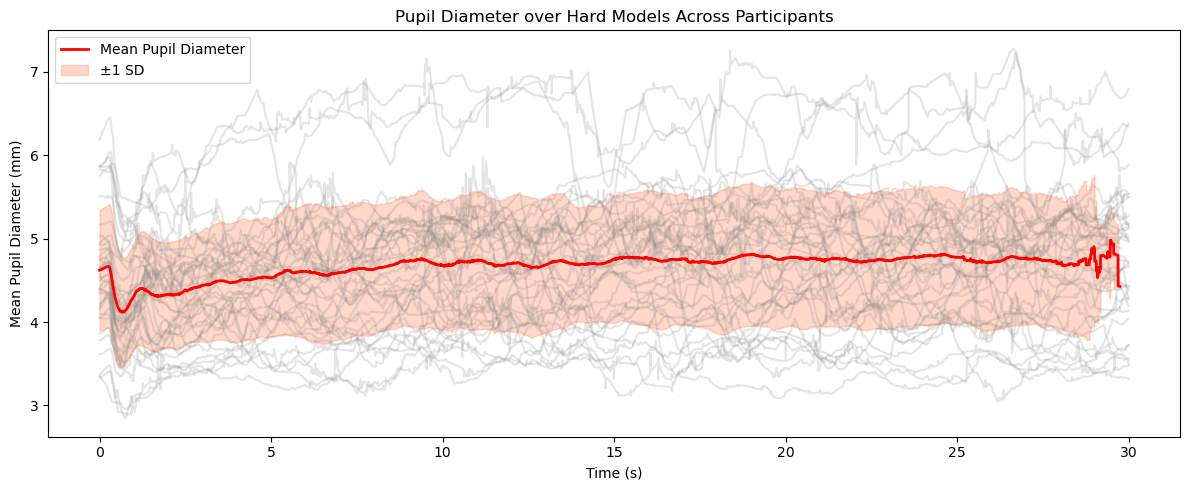

In [9]:
# Filter summary_df for the relevant models only

# easy_blocks = new_summary_df[new_summary_df['complexity'] == 'easy'] # Adjust for easy, moderate, and hard
# moderate_blocks = new_summary_df[new_summary_df['complexity'] == 'moderate']
hard_blocks = new_summary_df[new_summary_df['complexity'] == 'hard']

sampling_rate = 200  # samples per second
target_length = 30 * sampling_rate  # samples in 30 seconds

plt.figure(figsize=(12, 5))

all_segments = []

for (uid, model_num), group in hard_blocks.groupby(['UID', 'model_number']): # Adjust for easy, moderate, and hard
    block_id = group['block_id'].values[0]
    segment_df = combined_clean_df[(combined_clean_df['UID'] == uid) & (combined_clean_df['block_id'] == block_id)].copy()
    
    if segment_df.empty:
        continue
    
    segment_df['time_norm'] = segment_df['time'] - segment_df['time'].iloc[0]
    # Limit to first 30 seconds
    segment_df = segment_df[segment_df['time_norm'] <= 30]
    pupil_arr = segment_df['mean_pupil_diameter'].values
    
    if len(pupil_arr) == 0 or np.all(np.isnan(pupil_arr)):
        print(f"Skipping block: PID {uid}, model {model_num} due to empty or NaN data")
        continue
    
    # Pad with NaNs if shorter than target_length
    if len(pupil_arr) < target_length:
        pad_width = target_length - len(pupil_arr)
        pupil_arr = np.pad(pupil_arr, (0, pad_width), constant_values=np.nan)
    
    # Only append arrays that have at least one valid (non-NaN) value
    if np.isnan(pupil_arr).all():
        continue

    all_segments.append(pupil_arr)
    plt.plot(segment_df['time_norm'], segment_df['mean_pupil_diameter'], alpha=0.2, color='gray')

# Stack segments for mean/std calculation (shape: n_segments x target_length)
all_segments_arr = np.vstack(all_segments)

# Calculate mean and std ignoring NaNs
mean_pupil = np.nanmean(all_segments_arr, axis=0)
std_pupil = np.nanstd(all_segments_arr, axis=0)

# Create time axis in seconds for 30 seconds
time_axis = np.linspace(0, 30, target_length)

# Plot mean + shaded std
plt.plot(time_axis, mean_pupil, color='red', linewidth=2, label='Mean Pupil Diameter') # easy=yellow, moderate=orange, hard=red
plt.fill_between(time_axis, mean_pupil - std_pupil, mean_pupil + std_pupil,
                 color='coral', alpha=0.3, label='±1 SD') # easy=khaki, moderate=orange, hard=coral

plt.xlabel('Time (s)')
plt.ylabel('Mean Pupil Diameter (mm)')
plt.title('Pupil Diameter over Hard Models Across Participants') # Adjust for easy, moderate, and hard
plt.legend()
plt.tight_layout()
plt.show()

Direct comparison of mean pupil diameter per complexity level over time:

C:\Users\jonna\AppData\Local\Temp\ipykernel_21512\3386396636.py:47: RuntimeWarning: Mean of empty slice
  mean_pupil = np.nanmean(all_segments_arr, axis=0)
c:\Users\jonna\mne-python\1.9.0_0\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\jonna\AppData\Local\Temp\ipykernel_21512\3386396636.py:47: RuntimeWarning: Mean of empty slice
  mean_pupil = np.nanmean(all_segments_arr, axis=0)
c:\Users\jonna\mne-python\1.9.0_0\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\jonna\AppData\Local\Temp\ipykernel_21512\3386396636.py:47: RuntimeWarning: Mean of empty slice
  mean_pupil = np.nanmean(all_segments_arr, axis=0)
c:\Users\jonna\mne-python\1.9.0_0\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

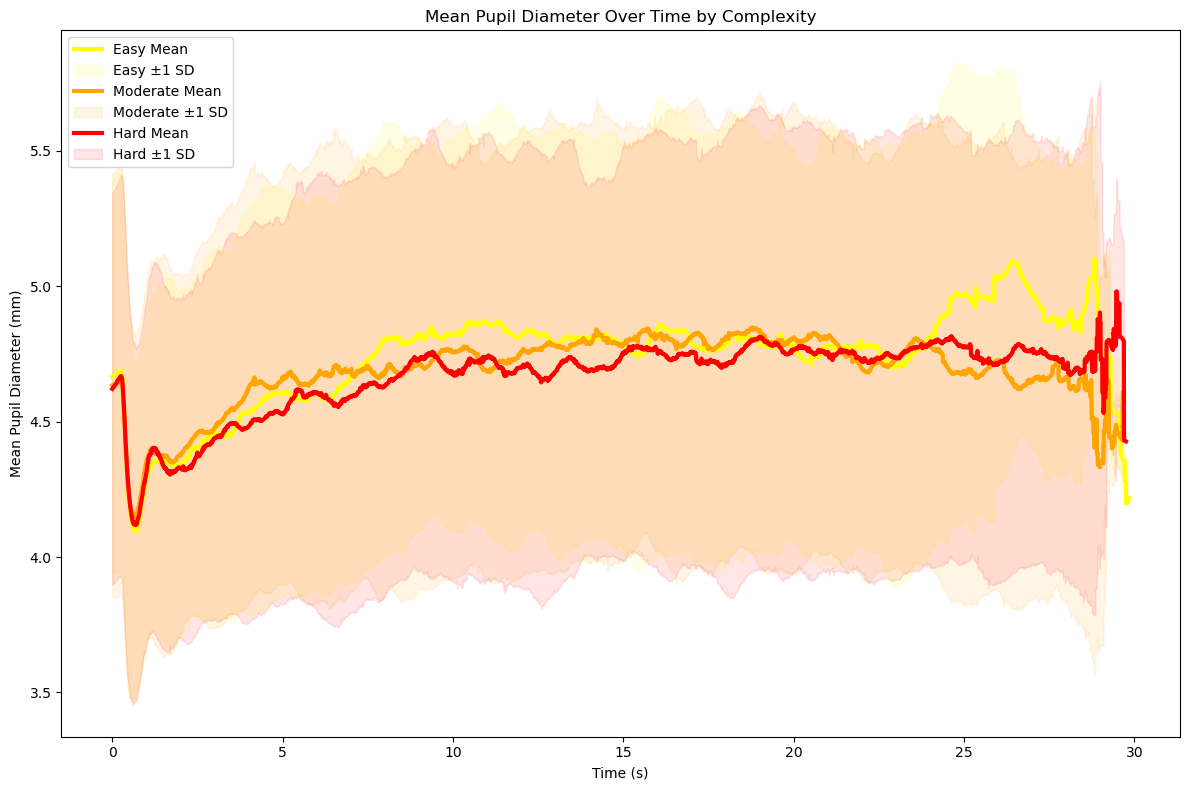

In [10]:
sampling_rate = 200
target_length = 30 * sampling_rate
time_axis = np.linspace(0, 30, target_length)

# Define colors for complexities
color_map = {
    'easy': 'yellow',
    'moderate': 'orange',
    'hard': 'red'
}

plt.figure(figsize=(12, 8))

for complexity in ['easy', 'moderate', 'hard']:
    # Filter summary for this complexity
    blocks = new_summary_df[new_summary_df['complexity'] == complexity]

    all_segments = []

    for (uid, model_num), group in blocks.groupby(['UID', 'model_number']):
        block_id = group['block_id'].values[0]
        segment_df = combined_clean_df[(combined_clean_df['UID'] == uid) & (combined_clean_df['block_id'] == block_id)].copy()

        if segment_df.empty:
            continue

        segment_df['time_norm'] = segment_df['time'] - segment_df['time'].iloc[0]
        segment_df = segment_df[segment_df['time_norm'] <= 30]

        pupil_arr = segment_df['mean_pupil_diameter'].values

        if len(pupil_arr) < target_length:
            pad_width = target_length - len(pupil_arr)
            pupil_arr = np.pad(pupil_arr, (0, pad_width), constant_values=np.nan)

        if np.isnan(pupil_arr).all():
            continue

        all_segments.append(pupil_arr)

    if not all_segments:
        print(f"No valid blocks for complexity '{complexity}'. Skipping.")
        continue

    all_segments_arr = np.vstack(all_segments)

    mean_pupil = np.nanmean(all_segments_arr, axis=0)
    std_pupil = np.nanstd(all_segments_arr, axis=0)

    # Plot mean line
    plt.plot(time_axis, mean_pupil, color=color_map[complexity], linewidth=3, label=f'{complexity.capitalize()} Mean')

    # Plot shaded ±1 SD
    plt.fill_between(time_axis, mean_pupil - std_pupil, mean_pupil + std_pupil,
                     color=color_map[complexity], alpha=0.1, label=f'{complexity.capitalize()} ±1 SD')

plt.xlabel('Time (s)')
plt.ylabel('Mean Pupil Diameter (mm)')
plt.title('Mean Pupil Diameter Over Time by Complexity')
plt.legend()
plt.tight_layout()
plt.show()

Boxplot for mean pupil diameter by complexity level: Individual participants

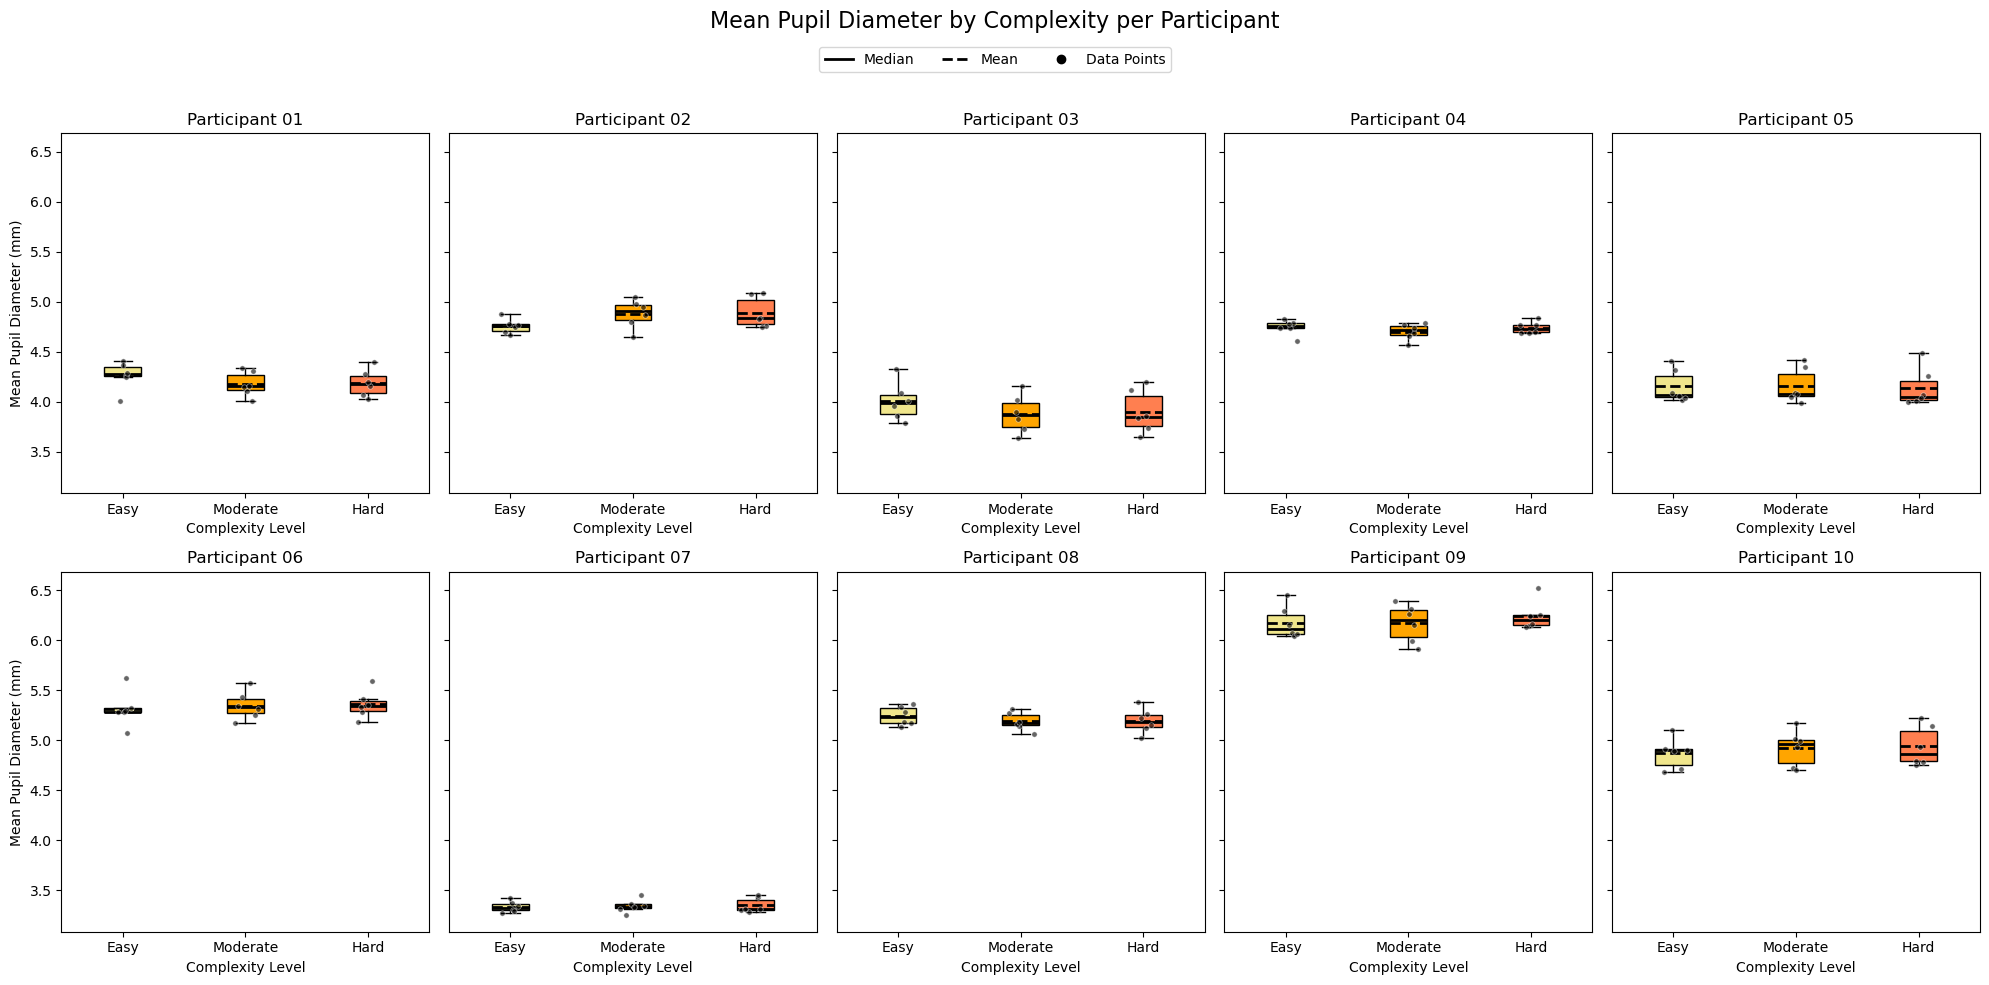

In [11]:
participants = final_summary_df['UID'].unique() 
complexities = ['easy', 'moderate', 'hard']
n_participants = len(participants)

n_cols = 5
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharey=True)
axes = axes.flatten()  # flatten for easy indexing

colors = ['khaki', 'orange', 'coral']

for i, participant in enumerate(participants):
    ax = axes[i]
    data = [final_summary_df[(final_summary_df['UID'] == participant) & 
                             (final_summary_df['complexity'] == c)]['mean_pupil_diameter_in_mm'] for c in complexities]

    # Plot boxplot
    box = ax.boxplot(data, patch_artist=True, showmeans=True, meanline=True, showfliers=False,
                     meanprops={'color': 'black', 'linewidth': 2},
                     zorder=1)

    # Customize median lines
    for median in box['medians']:
        median.set(color='black', linewidth=2)

    # Set box colors
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Set x labels & titles
    ax.set_xticklabels([c.capitalize() for c in complexities])
    ax.set_xlabel('Complexity Level')
    ax.set_title(f'Participant {participant}')

    # Overlay data points with jitter
    for j, c in enumerate(complexities, start=1):
        y = final_summary_df[(final_summary_df['UID'] == participant) & (final_summary_df['complexity'] == c)]['mean_pupil_diameter_in_mm']
        x = np.random.normal(loc=j, scale=0.05, size=len(y))
        ax.scatter(x, y, color='black', alpha=0.6, s=15, edgecolor='white', linewidth=0.5, zorder=2)

    if i % n_cols == 0:
        ax.set_ylabel('Mean Pupil Diameter (mm)')

# Remove empty subplots if any
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Add a single legend on the figure (using one of the axes)
median_line = mlines.Line2D([], [], color='black', linewidth=2, label='Median')
mean_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2, label='Mean')
data_points = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Data Points')

fig.legend(handles=[median_line, mean_line, data_points], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.95))

fig.suptitle('Mean Pupil Diameter by Complexity per Participant', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

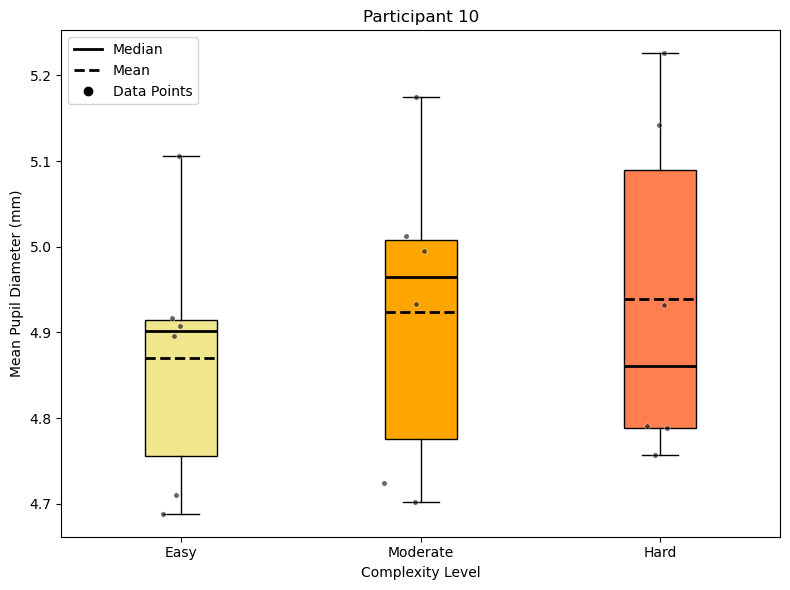

In [12]:
def plot_participant_pupil_data(df, participant_id):
    complexities = ['easy', 'moderate', 'hard']
    colors = ['khaki', 'orange', 'coral']
    
    fig, ax = plt.subplots(figsize=(8, 6))

    data = [df[(df['UID'] == participant_id) & 
               (df['complexity'] == c)]['mean_pupil_diameter_in_mm'] for c in complexities]

    box = ax.boxplot(data, patch_artist=True, showmeans=True, meanline=True,
                 showfliers=False,  # hides outliers if desired
                 meanprops={'color': 'black', 'linewidth': 2},
                 zorder=1)

    # Customize median line color
    for median in box['medians']:
        median.set(color='black', linewidth=2)

    # Box face colors
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_xticklabels([c.capitalize() for c in complexities])
    ax.set_xlabel('Complexity Level')
    ax.set_ylabel('Mean Pupil Diameter (mm)')
    ax.set_title(f'Participant {participant_id}')

    # Overlay scatter points with jitter
    for i, c in enumerate(complexities, start=1):
        y = df[(df['UID'] == participant_id) & (df['complexity'] == c)]['mean_pupil_diameter_in_mm']
        x = np.random.normal(loc=i, scale=0.05, size=len(y))
        ax.scatter(x, y, color='black', alpha=0.6, s=15, edgecolor='white', linewidth=0.5, zorder=2)

    # Legend
    median_line = mlines.Line2D([], [], color='black', linewidth=2, label='Median')
    mean_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2, label='Mean')
    data_points = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Data Points')
    ax.legend(handles=[median_line, mean_line, data_points])

    plt.tight_layout()
    plt.show()
    
# Plot participant:
plot_participant_pupil_data(final_summary_df, '10') # Change UID for different participants

Boxplot for mean pupil diameter by complexity level: All participants

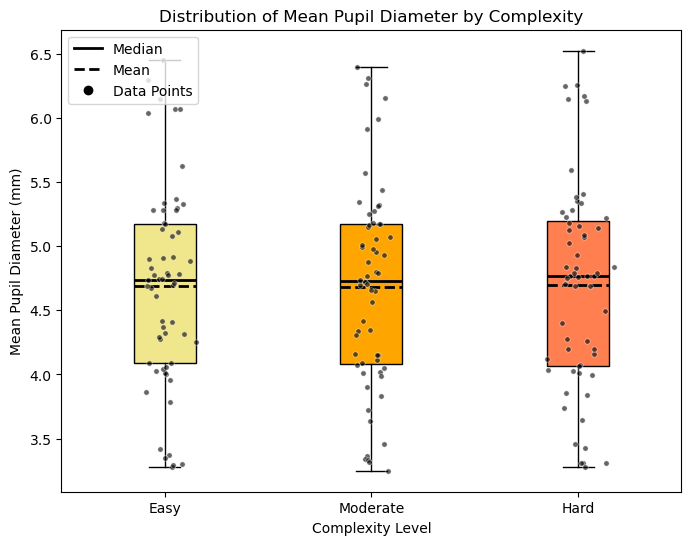

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

data = [final_summary_df[final_summary_df['complexity'] == c]['mean_pupil_diameter_in_mm'] for c in ['easy', 'moderate', 'hard']]

# Plot boxplot with low zorder so points can appear on top
box = ax.boxplot(data, patch_artist=True, showmeans=True, meanline=True,
                 meanprops={'color': 'black', 'linewidth': 2},
                 zorder=1)

# Customize median line color:
for median in box['medians']:
    median.set(color='black', linewidth=2)

colors = ['khaki', 'orange', 'coral']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(['Easy', 'Moderate', 'Hard'])
ax.set_xlabel('Complexity Level')
ax.set_ylabel('Mean Pupil Diameter (mm)')
ax.set_title('Distribution of Mean Pupil Diameter by Complexity')

# Overlay data points with higher zorder so they appear on top
for i, complexity in enumerate(['easy', 'moderate', 'hard'], start=1):
    y = final_summary_df[final_summary_df['complexity'] == complexity]['mean_pupil_diameter_in_mm']
    
    # Add horizontal jitter for better visibility
    x = np.random.normal(loc=i, scale=0.05, size=len(y))
    
    ax.scatter(x, y, color='black', alpha=0.6, s=15, edgecolor='white', linewidth=0.5, zorder=2)

# Custom legend handles
median_line = mlines.Line2D([], [], color='black', linewidth=2, label='Median')
mean_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2, label='Mean')
data_points = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Data Points')
ax.legend(handles=[median_line, mean_line, data_points])

plt.show()

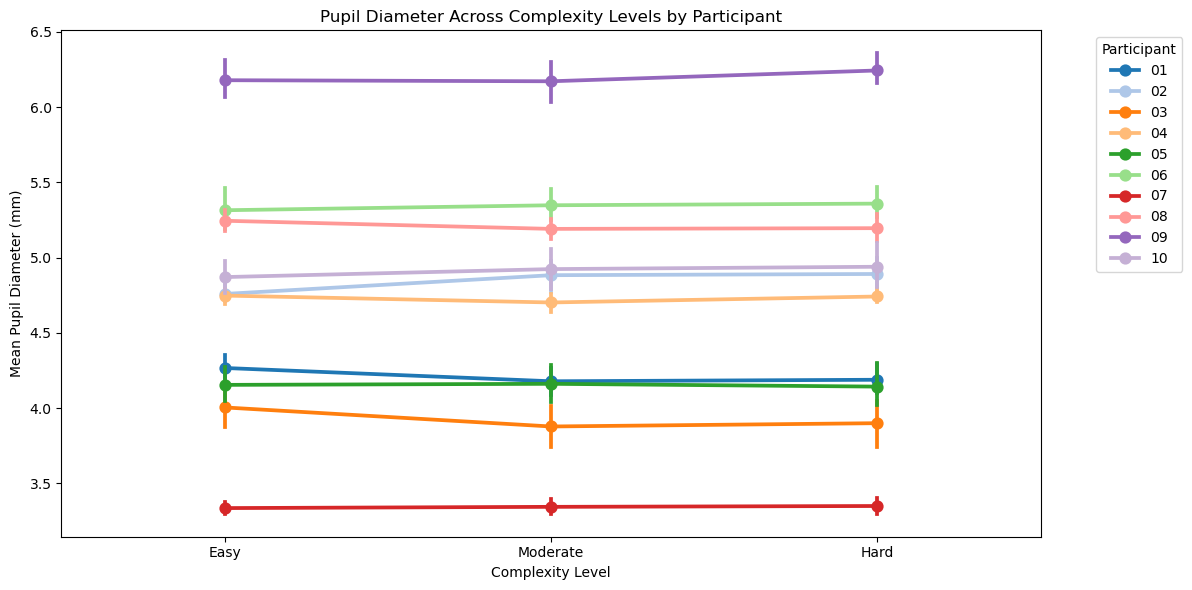

In [14]:
# Ensure correct order of complexities
complexity_order = ['easy', 'moderate', 'hard']

plt.figure(figsize=(12, 6))

# Pointplot with each participant as a separate line
sns.pointplot(
    data=final_summary_df,
    x='complexity',
    y='mean_pupil_diameter_in_mm',
    hue='UID',                       # Each participant is a separate line
    order=complexity_order,          # Ensure correct x-axis order
    dodge=False,                     # Keep points aligned
    markers='o',
    linestyles='-',
    palette='tab20'                  # Large palette for many participants
)

plt.xlabel("Complexity Level")
plt.ylabel("Mean Pupil Diameter (mm)")
plt.title("Pupil Diameter Across Complexity Levels by Participant")
plt.xticks(ticks=range(len(complexity_order)), labels=[c.capitalize() for c in complexity_order])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Participant")
plt.tight_layout()
plt.show()

Boxplot for mean pupil diameter by complexity and familiarity:

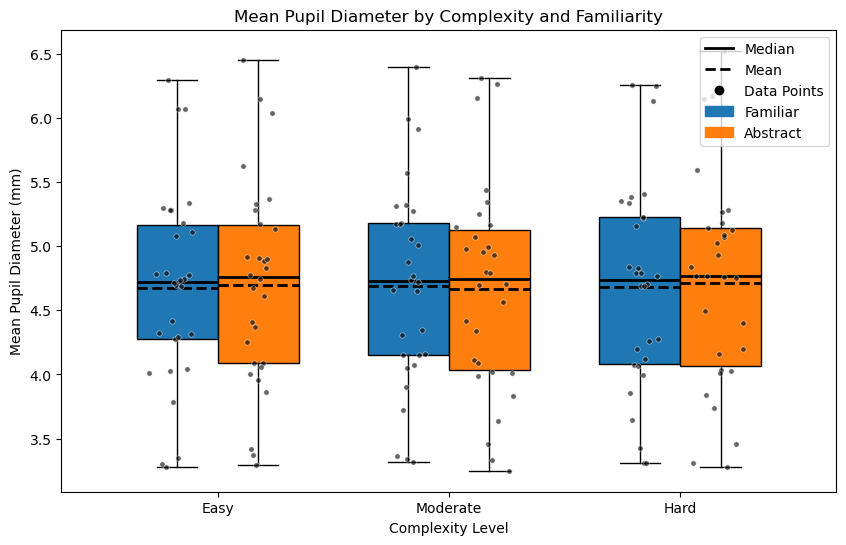

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

complexities = ['easy', 'moderate', 'hard']
familiarities = ['familiar', 'abstract']

box_width = 0.35
positions = []
positions_labels = []

for i, comp in enumerate(complexities):
    center = i + 1
    positions.extend([center - box_width/2, center + box_width/2])
    positions_labels.append(center)

# Map familiarity to colors (using seaborn default palette for consistency)
fam_colors = sns.color_palette(n_colors=2)

# Prepare data groups
data_groups = []
for comp in complexities:
    for fam in familiarities:
        subset = final_summary_df[
            (final_summary_df['complexity'] == comp) & 
            (final_summary_df['familiarity'] == fam)
        ]['mean_pupil_diameter_in_mm']
        data_groups.append(subset)

# Create boxplot
box = ax.boxplot(data_groups, positions=positions, widths=box_width, patch_artist=True, showmeans=True,
                 meanline=True, meanprops={'color': 'black', 'linewidth': 2}, zorder=1)

# Color the boxes by familiarity colors alternately
for i, patch in enumerate(box['boxes']):
    color = fam_colors[i % 2]  # 0 for familiar, 1 for abstract
    patch.set_facecolor(color)

# Customize median line color
for median in box['medians']:
    median.set(color='black', linewidth=2)

ax.set_xticks(positions_labels)
ax.set_xticklabels([c.capitalize() for c in complexities])
ax.set_xlabel('Complexity Level')
ax.set_ylabel('Mean Pupil Diameter (mm)')
ax.set_title('Mean Pupil Diameter by Complexity and Familiarity')

# Overlay scatter points (black) with jitter
for i, subset in enumerate(data_groups):
    x_jitter = np.random.normal(loc=positions[i], scale=0.05, size=len(subset))
    ax.scatter(x_jitter, subset, color='black', alpha=0.6, s=15, edgecolor='white', linewidth=0.5, zorder=2,
               label='Data Points' if i == 0 else None)

# Create legend handles
median_line = mlines.Line2D([], [], color='black', linewidth=2, label='Median')
mean_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2, label='Mean')
data_points = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Data Points')
familiar_patch = mpatches.Patch(color=fam_colors[0], label='Familiar')
abstract_patch = mpatches.Patch(color=fam_colors[1], label='Abstract')

ax.legend(handles=[median_line, mean_line, data_points, familiar_patch, abstract_patch], loc='best')

plt.show()

Boxplot for mean pupil diameter by familiarity:

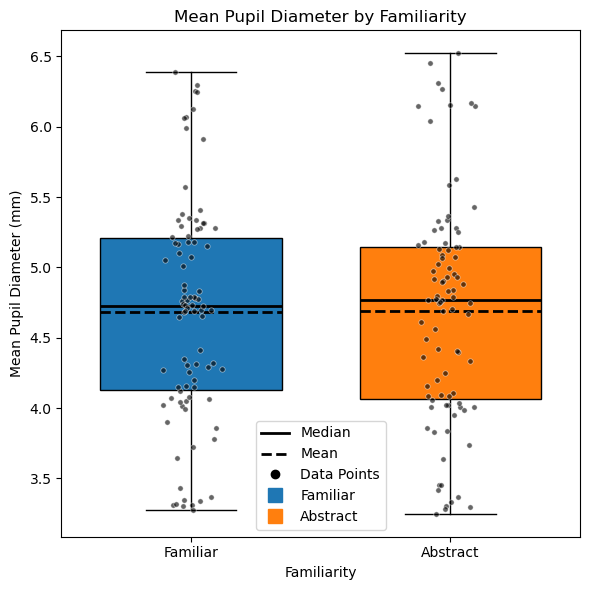

In [16]:
# Get Seaborn default colors for 2 categories (familiar and abstract)
fam_colors = sns.color_palette(n_colors=2)

groups = ['Familiar', 'Abstract']

# Capitalize familiarity labels for x-axis
final_summary_df['familiarity'] = final_summary_df['familiarity'].str.capitalize()

data = [final_summary_df[final_summary_df['familiarity'] == label]['mean_pupil_diameter_in_mm'] for label in groups]

fig, ax = plt.subplots(figsize=(6, 6))

# Plot boxplot with patch artist and mean lines
box = ax.boxplot(data,
                 patch_artist=True,
                 showmeans=True,
                 meanline=True,
                 meanprops={'color': 'black', 'linewidth': 2},
                 medianprops={'color': 'black', 'linewidth': 2},
                 boxprops={'zorder': 2},
                 whiskerprops={'zorder': 2},
                 capprops={'zorder': 2},
                widths=0.7)

# Color boxes with Seaborn colors
for patch, color in zip(box['boxes'], fam_colors):
    patch.set_facecolor(color)
    patch.set_zorder(2)  # behind scatter points

# Set x-axis labels
ax.set_xticklabels(groups)
ax.set_xlabel('Familiarity')
ax.set_ylabel('Mean Pupil Diameter (mm)')
ax.set_title('Mean Pupil Diameter by Familiarity')

# Overlay scatter points with jitter and zorder on top
for i, y in enumerate(data, start=1):
    x_jitter = np.random.normal(loc=i, scale=0.05, size=len(y))
    ax.scatter(x_jitter, y,
               color='black',
               alpha=0.6,
               edgecolor='white',
               linewidth=0.5,
               s=15,
               label='Data Points' if i == 1 else None,
               zorder=3)

# Create legend handles
median_line = mlines.Line2D([], [], color='black', linewidth=2, label='Median')
mean_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2, label='Mean')
data_points = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Data Points')
familiar_patch = mlines.Line2D([], [], color=fam_colors[0], marker='s', linestyle='None', markersize=10, label='Familiar')
abstract_patch = mlines.Line2D([], [], color=fam_colors[1], marker='s', linestyle='None', markersize=10, label='Abstract')

ax.legend(handles=[median_line, mean_line, data_points, familiar_patch, abstract_patch])

plt.tight_layout()
plt.show()

## Statistical Analysis - Pupil Diameter

Check normality distrubution of cleaned pupil diameter data across all participants:

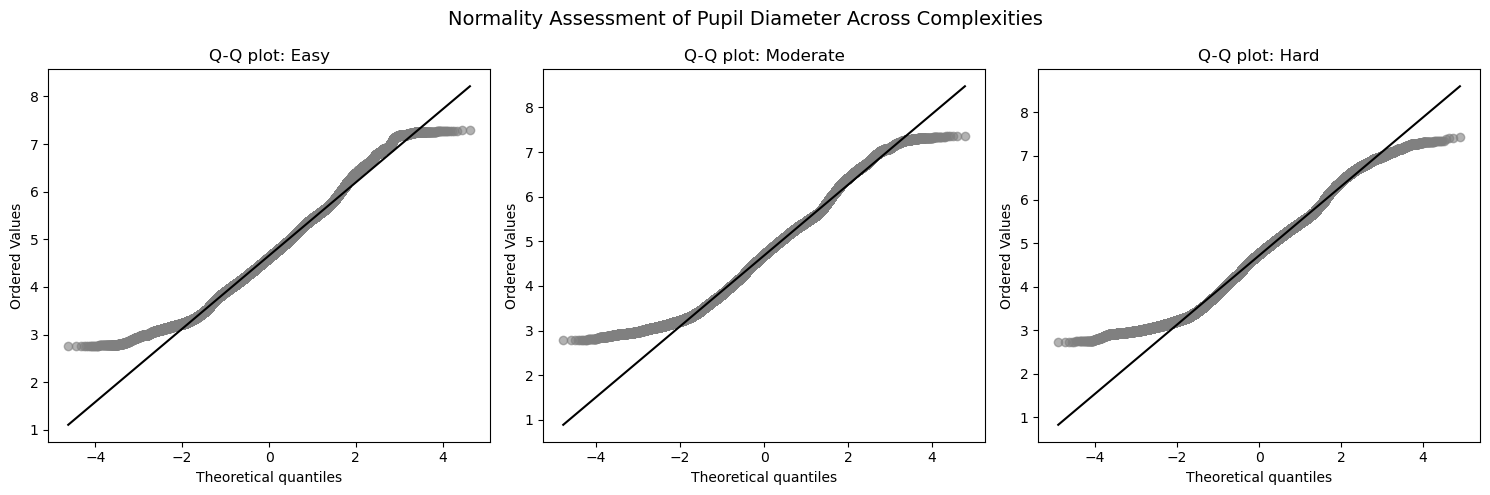

In [17]:
def get_complexity(model_name):
    complexity_code = model_name[:2].upper() if isinstance(model_name, str) else ''
    return {'C1': 'easy', 'C2': 'moderate', 'C3': 'hard'}.get(complexity_code, 'unknown')

desired_order = ['easy', 'moderate', 'hard']

# Apply to your dataframe
combined_clean_df['complexity'] = combined_clean_df['model_name'].apply(get_complexity)

# Filter out rows with complexity 'unknown'
combined_clean_df = combined_clean_df[combined_clean_df['complexity'] != 'unknown'].copy()

# Convert the Complexity column to ordered categorical
combined_clean_df['complexity'] = pd.Categorical(combined_clean_df['complexity'], categories=desired_order, ordered=True)

# 1. Select only necessary columns
data = combined_clean_df[['complexity', 'mean_pupil_diameter']].dropna()

# 2. Get unique complexity levels
complexity_levels = data['complexity'].unique()

# 3. Plot Q-Q plots per complexity condition
fig, axs = plt.subplots(1, len(desired_order), figsize=(15, 5))

for i, level in enumerate(desired_order):
    subset = data[data['complexity'] == level]['mean_pupil_diameter']
    stats.probplot(subset, dist="norm", plot=axs[i])
    # Change line color (usually the red line)
    for line in axs[i].get_lines():
        # line 0 is the points, line 1 is the reference line
        if line.get_linestyle() == '-':  # solid line assumed to be the reference line
            line.set_color('black')
            line.set_linewidth(1.5)
        else:
            line.set_color('gray')
            line.set_alpha(0.6)
    axs[i].set_title(f'Q-Q plot: {level.capitalize()}')

fig.suptitle('Normality Assessment of Pupil Diameter Across Complexities', fontsize=14)

plt.tight_layout()
plt.show()

In [18]:
# Aggregate means
agg = combined_clean_df.groupby(['UID', 'complexity'])['mean_pupil_diameter'].mean().reset_index()

# Test per complexity level
for complexity_level in ['easy', 'moderate', 'hard']:
    data = agg[agg['complexity'] == complexity_level]['mean_pupil_diameter']
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk test for {complexity_level}: stat={stat:.3f}, p={p:.3f}")

Shapiro-Wilk test for easy: stat=0.984, p=0.984
Shapiro-Wilk test for moderate: stat=0.982, p=0.973
Shapiro-Wilk test for hard: stat=0.979, p=0.959


C:\Users\jonna\AppData\Local\Temp\ipykernel_21512\2219680148.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = combined_clean_df.groupby(['UID', 'complexity'])['mean_pupil_diameter'].mean().reset_index()


### Linear Mixed Model

In [19]:
import statsmodels.formula.api as smf

# Select the relevant columns into a new DataFrame
PD_LMM = final_summary_df[['UID', 'mean_pupil_diameter_in_mm', 'complexity', 'familiarity', 'condition']].copy()

# Rename for convenience
PD_LMM.rename(columns={'mean_pupil_diameter_in_mm': 'mean_pupil_diameter'}, inplace=True)

# Convert categorical predictors
PD_LMM['complexity'] = pd.Categorical(PD_LMM['complexity'], categories=['easy', 'moderate', 'hard'], ordered=True)
PD_LMM['familiarity'] = PD_LMM['familiarity'].astype('category')
PD_LMM['condition'] = PD_LMM['condition'].astype('category')
PD_LMM['UID'] = PD_LMM['UID'].astype('category')

# Define the mixed model (main effects only, no interactions)
model = smf.mixedlm(
    "mean_pupil_diameter ~ complexity + familiarity + condition",
    data=PD_LMM,
    groups=PD_LMM["UID"],
    re_formula="~1"   # random intercepts only
)

# Fit the model
result = model.fit(method='powell')
print(result.summary())

# Since the intercept considers easy and abstract models and LMMs report abstract coefficients, M and SD for mean is computed
easy_mean = PD_LMM.loc[PD_LMM['complexity'] == 'easy', 'mean_pupil_diameter'].mean()
easy_sd = PD_LMM.loc[PD_LMM['complexity'] == 'easy', 'mean_pupil_diameter'].std()

print(f"Easy models: M = {easy_mean:.2f}, SD = {easy_sd:.2f}")

abstract_mean = PD_LMM.loc[PD_LMM['familiarity'] == 'abstract', 'mean_pupil_diameter'].mean()
abstract_sd = PD_LMM.loc[PD_LMM['familiarity'] == 'abstract', 'mean_pupil_diameter'].std()

print(f"Abstract models: M = {abstract_mean:.2f}, SD = {abstract_sd:.2f}")


               Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: mean_pupil_diameter
No. Observations:   180     Method:             REML               
No. Groups:         10      Scale:              0.0103             
Min. group size:    18      Log-Likelihood:     108.2317           
Max. group size:    18      Converged:          Yes                
Mean group size:    18.0                                           
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                4.821    0.258  18.699 0.000  4.316  5.327
complexity[T.moderate]  -0.010    0.018  -0.517 0.605 -0.046  0.027
complexity[T.hard]       0.007    0.018   0.401 0.688 -0.029  0.044
familiarity[T.Familiar] -0.011    0.015  -0.730 0.465 -0.041  0.019
condition[T.2]          -0.154    0.018  -8.322 0.000 -0.190 -0

## Descriptive Analysis - Blinks

Heatmap for blink rate for all participants over all models:

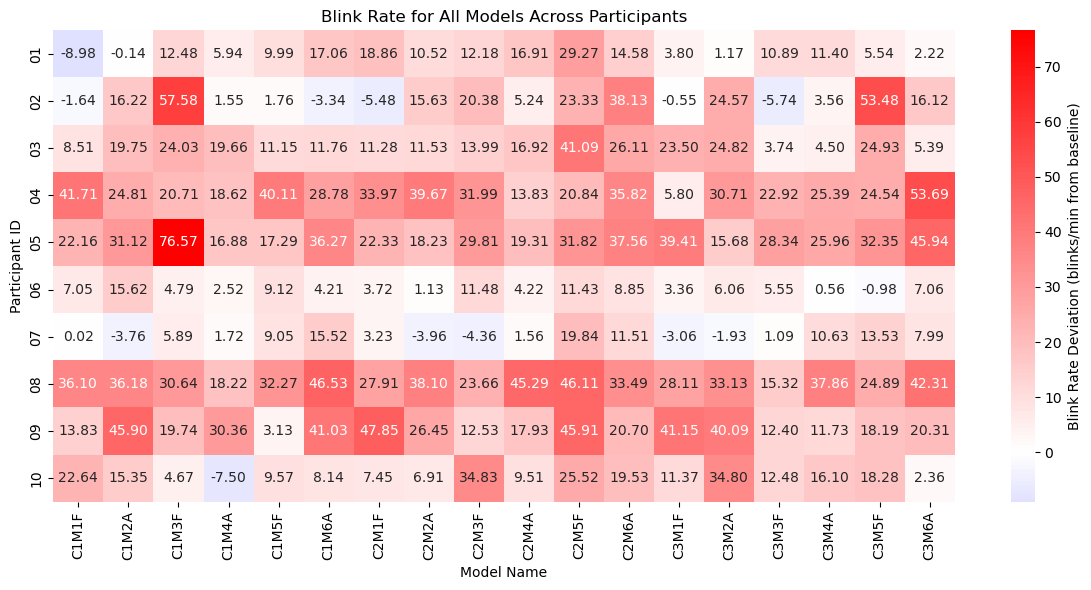

In [20]:
# Baseline blink rate in blinks per minute
baseline_bl = 20

def normalize_blink_rate(row):
    # blink_count and trial_duration_in_sec are columns in final_summary_df
    duration_min = row['trial_duration_in_sec'] / 60.0
    if duration_min == 0:
        return np.nan  # Avoid division by zero
    blink_rate = row['blink_count'] / duration_min
    return blink_rate - baseline_bl

final_summary_df['blink_rate'] = final_summary_df.apply(normalize_blink_rate, axis=1)

# Create combined model key
final_summary_df['model_key'] = final_summary_df['condition'].astype(str) + '-' + final_summary_df['model_number'].astype(str)

# Map model keys to model names
model_key_to_name = final_summary_df.drop_duplicates(subset='model_key').set_index('model_key')['model_name'].to_dict()

# Pivot with updated blink_rate
pivot_df_unique = final_summary_df.pivot(index='UID', columns='model_key', values='blink_rate')

pivot_df_unique = pivot_df_unique.rename(columns=model_key_to_name)

model_names = list(pivot_df_unique.columns)

def sort_key(name):
    match = re.match(r'(C\d)M(\d)', name)
    if match:
        return (match.group(1), int(match.group(2)))
    else:
        return (name, 0)

sorted_model_names = sorted(model_names, key=sort_key)
pivot_df_unique = pivot_df_unique[sorted_model_names]

plt.figure(figsize=(12, 6))

sns.heatmap(pivot_df_unique, cmap='bwr', center=0, annot=True, fmt=".2f",
            cbar_kws={'label': 'Blink Rate Deviation (blinks/min from baseline)'})

plt.title('Blink Rate for All Models Across Participants')
plt.xlabel('Model Name')
plt.ylabel('Participant ID')
plt.tight_layout()
plt.show()

## Descriptive Analysis - Complexity Questionnaire

Boxplot for complexity-questionnaire:

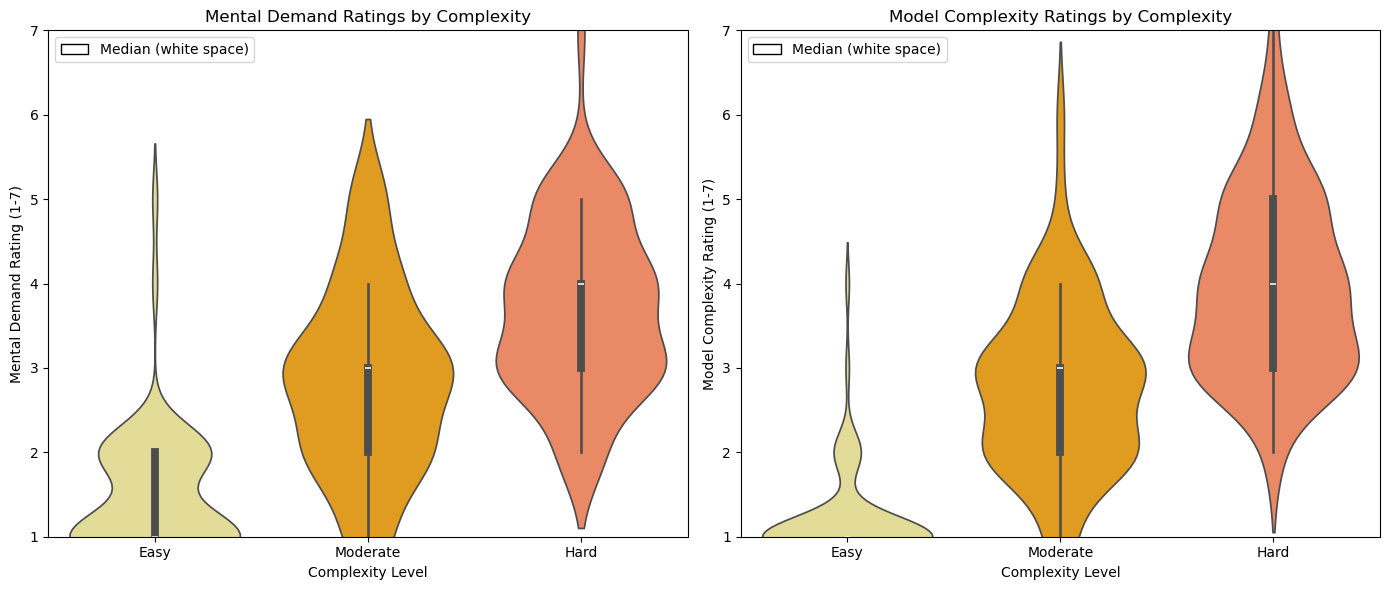

In [21]:
median_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='Median (white space)')

complexity_order = ['easy', 'moderate', 'hard']

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.violinplot(data=final_summary_df,
               x="complexity", y="mental_demand_rating",
               hue='complexity',
               order=complexity_order,
               inner='box',
               palette=['coral', 'orange', 'khaki'],
               legend=False)

plt.title('Mental Demand Ratings by Complexity')
plt.xlabel('Complexity Level')
plt.xticks(ticks=[0, 1, 2], labels=['Easy', 'Moderate', 'Hard'])
plt.ylabel('Mental Demand Rating (1-7)')
plt.ylim(1, 7)
plt.legend(handles=[median_patch])

plt.subplot(1, 2, 2)
sns.violinplot(data=final_summary_df,
               x='complexity', y='complexity_rating',
               hue='complexity',
               order=complexity_order,
               inner='box',
               palette=['coral', 'orange', 'khaki'],
               legend=False)

plt.title('Model Complexity Ratings by Complexity')
plt.xlabel('Complexity Level')
plt.xticks(ticks=[0, 1, 2], labels=['Easy', 'Moderate', 'Hard'])
plt.ylabel('Model Complexity Rating (1-7)')
plt.ylim(1, 7)
plt.legend(handles=[median_patch])
plt.tight_layout()
plt.show()

Boxplot for complexity-questionnaire including familiarity:

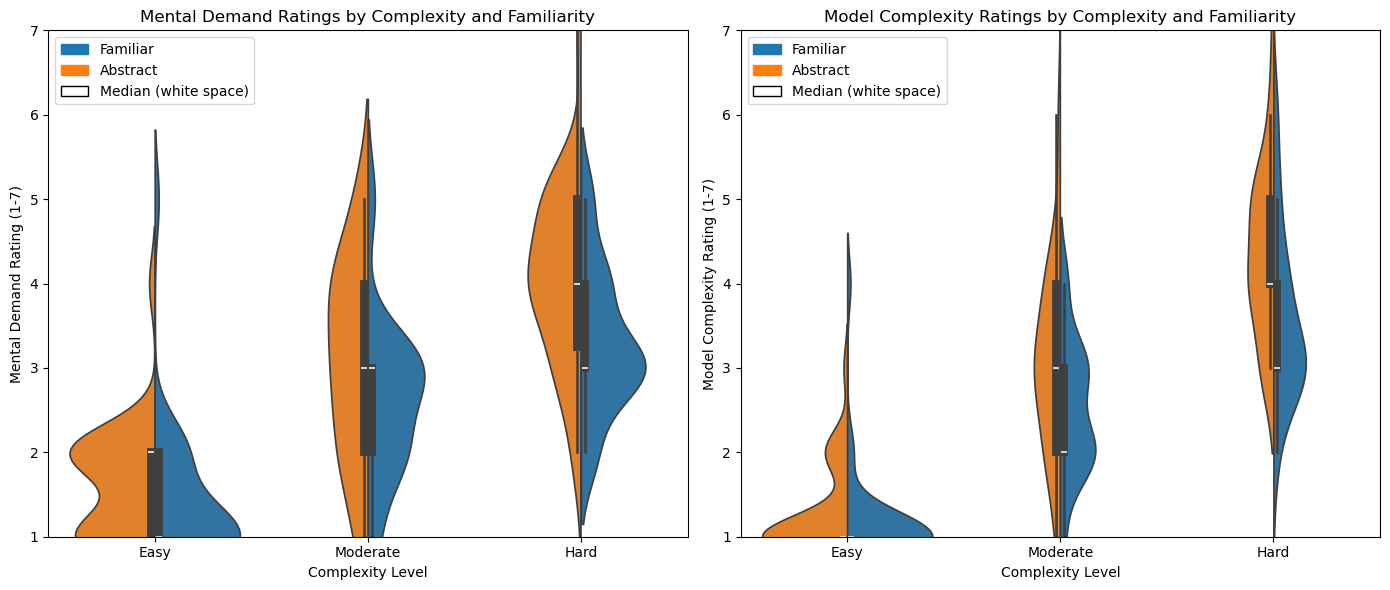

In [22]:
median_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='Median (white space)')

complexity_order = ['easy', 'moderate', 'hard']

# Enforce lowercase familiarity labels on DataFrame
final_summary_df['familiarity'] = final_summary_df['familiarity'].str.lower()

plt.figure(figsize=(14, 6))

ax1 = plt.subplot(1, 2, 1)
sns.violinplot(data=final_summary_df,
               x='complexity', y='mental_demand_rating',
               hue='familiarity',
               order=complexity_order,
               inner='box',
               palette={'familiar': 'tab:blue', 'abstract': 'tab:orange'},
               split=True,
               legend=False)

ax1.set_title('Mental Demand Ratings by Complexity and Familiarity')
ax1.set_xlabel('Complexity Level')
ax1.set_ylabel('Mental Demand Rating (1-7)')
ax1.set_ylim(1, 7)
ax1.set_xticks(range(len(complexity_order)))
ax1.set_xticklabels([label.capitalize() for label in complexity_order])

# Create manual legend with capitalized labels
familiar_patch = mpatches.Patch(color='tab:blue', label='Familiar')
abstract_patch = mpatches.Patch(color='tab:orange', label='Abstract')

handles = [familiar_patch, abstract_patch, median_patch]
ax1.legend(handles=handles, title=None, loc='best')

ax2 = plt.subplot(1, 2, 2)
sns.violinplot(data=final_summary_df,
               x='complexity', y='complexity_rating',
               hue='familiarity',
               order=complexity_order,
               inner='box',
               palette={'familiar': 'tab:blue', 'abstract': 'tab:orange'},
               split=True,
               legend=False)

ax2.set_title('Model Complexity Ratings by Complexity and Familiarity')
ax2.set_xlabel('Complexity Level')
ax2.set_ylabel('Model Complexity Rating (1-7)')
ax2.set_ylim(1, 7)
ax2.set_xticks(range(len(complexity_order)))
ax2.set_xticklabels([label.capitalize() for label in complexity_order])

handles2 = [familiar_patch, abstract_patch, median_patch]
ax2.legend(handles=handles2, title=None, loc='best')

plt.tight_layout()
plt.show()

## Statistical Analysis (Anova) - Complexity Questionnaire

Check for normal distribution:

In [23]:
# Remove NaNs before testing
mental_data = final_summary_df['mental_demand_rating'].dropna()
complexity_data = final_summary_df['complexity_rating'].dropna()

# Shapiro-Wilk test for mental demand
stat_md, p_md = shapiro(mental_data)
print(f'Shapiro-Wilk test for mental_demand_rating: statistic={stat_md:.4f}, p-value={p_md:.4f}')

# Shapiro-Wilk test for model complexity
stat_comp, p_comp = shapiro(complexity_data)
print(f'Shapiro-Wilk test for complexity_rating: statistic={stat_comp:.4f}, p-value={p_comp:.4f}')

for comp in final_summary_df['complexity'].unique():
    # Subset data for this complexity
    md_sub = final_summary_df[final_summary_df['complexity'] == comp]['mental_demand_rating'].dropna()
    comp_sub = final_summary_df[final_summary_df['complexity'] == comp]['complexity_rating'].dropna()
    
    stat_md, p_md = shapiro(md_sub)
    stat_comp, p_comp = shapiro(comp_sub)
    
    print(f'Complexity: {comp}')
    print(f'  Mental Demand rating: statistic={stat_md:.4f}, p-value={p_md:.4f}')
    print(f'  Complexity rating: statistic={stat_comp:.4f}, p-value={p_comp:.4f}\n')

Shapiro-Wilk test for mental_demand_rating: statistic=0.9054, p-value=0.0000
Shapiro-Wilk test for complexity_rating: statistic=0.8941, p-value=0.0000
Complexity: hard
  Mental Demand rating: statistic=0.8912, p-value=0.0001
  Complexity rating: statistic=0.8926, p-value=0.0001

Complexity: moderate
  Mental Demand rating: statistic=0.9087, p-value=0.0003
  Complexity rating: statistic=0.8905, p-value=0.0001

Complexity: easy
  Mental Demand rating: statistic=0.6179, p-value=0.0000
  Complexity rating: statistic=0.4457, p-value=0.0000



### Linear Mixed Model - Mental Demand

In [24]:
columns_to_keep = ['UID', 'complexity', 'familiarity', 'condition', 'mental_demand_rating']
MentDem_LMM = final_summary_df[columns_to_keep].copy()

# Ensure categorical coding
MentDem_LMM['complexity'] = MentDem_LMM['complexity'].astype('category')
MentDem_LMM['familiarity'] = MentDem_LMM['familiarity'].astype('category')
MentDem_LMM['condition'] = MentDem_LMM['condition'].astype('category')
MentDem_LMM['UID'] = MentDem_LMM['UID'].astype('category')

# LMM with ONLY main effects
model = smf.mixedlm(
    "mental_demand_rating ~ complexity + familiarity + condition",
    data=MentDem_LMM,
    groups=MentDem_LMM["UID"],
    re_formula="~1"   # random intercepts for participants
)

result = model.fit(method='powell')
print(result.summary())

# Since the intercept considers easy and abstract models and LMMs report abstract coefficients, M and SD for mean is computed
easy_mean = MentDem_LMM.loc[MentDem_LMM['complexity'] == 'easy', 'mental_demand_rating'].mean()
easy_sd = MentDem_LMM.loc[MentDem_LMM['complexity'] == 'easy', 'mental_demand_rating'].std()

print(f"Easy models: M = {easy_mean:.2f}, SD = {easy_sd:.2f}")

abstract_mean = MentDem_LMM.loc[MentDem_LMM['familiarity'] == 'abstract', 'mental_demand_rating'].mean()
abstract_sd = MentDem_LMM.loc[MentDem_LMM['familiarity'] == 'abstract', 'mental_demand_rating'].std()

print(f"Abstract models: M = {abstract_mean:.2f}, SD = {abstract_sd:.2f}")


              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mental_demand_rating
No. Observations: 180     Method:             REML                
No. Groups:       10      Scale:              0.5759              
Min. group size:  18      Log-Likelihood:     -220.8802           
Max. group size:  18      Converged:          Yes                 
Mean group size:  18.0                                            
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                1.517    0.220  6.904 0.000  1.086  1.947
complexity[T.hard]       2.183    0.139 15.758 0.000  1.912  2.455
complexity[T.moderate]   1.333    0.139  9.623 0.000  1.062  1.605
familiarity[T.familiar] -0.478    0.113 -4.223 0.000 -0.700 -0.256
condition[T.2]           0.383    0.139  2.767 0.006  0.112  0.655
condition[

### Linear Mixed Model - Structural Complexity

In [25]:
columns_to_keep = ['UID', 'complexity', 'familiarity', 'condition', 'complexity_rating']
Comp_LMM = final_summary_df[columns_to_keep].copy()

# Ensure categorical coding
Comp_LMM['complexity'] = Comp_LMM['complexity'].astype('category')
Comp_LMM['familiarity'] = Comp_LMM['familiarity'].astype('category')
Comp_LMM['condition'] = Comp_LMM['condition'].astype('category')
Comp_LMM['UID'] = Comp_LMM['UID'].astype('category')

# LMM with ONLY main effects
model = smf.mixedlm(
    "complexity_rating ~ complexity + familiarity + condition",
    data=Comp_LMM,
    groups=Comp_LMM["UID"],
    re_formula="~1"   # random intercepts for participants
)

result = model.fit(method='powell')
print(result.summary())

# Since easy is the intercept complexity and LMMs report abstract coefficients, M and SD for mean is computed
easy_mean = Comp_LMM.loc[Comp_LMM['complexity'] == 'easy', 'complexity_rating'].mean()
easy_sd = Comp_LMM.loc[Comp_LMM['complexity'] == 'easy', 'complexity_rating'].std()

print(f"Easy models: M = {easy_mean:.2f}, SD = {easy_sd:.2f}")

abstract_mean = Comp_LMM.loc[Comp_LMM['familiarity'] == 'abstract', 'complexity_rating'].mean()
abstract_sd = Comp_LMM.loc[Comp_LMM['familiarity'] == 'abstract', 'complexity_rating'].std()

print(f"Abstract models: M = {abstract_mean:.2f}, SD = {abstract_sd:.2f}")


              Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  complexity_rating
No. Observations:  180      Method:              REML             
No. Groups:        10       Scale:               0.5901           
Min. group size:   18       Log-Likelihood:      -220.6896        
Max. group size:   18       Converged:           Yes              
Mean group size:   18.0                                           
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                1.272    0.190  6.685 0.000  0.899  1.645
complexity[T.hard]       2.750    0.140 19.608 0.000  2.475  3.025
complexity[T.moderate]   1.550    0.140 11.052 0.000  1.275  1.825
familiarity[T.familiar] -0.478    0.115 -4.172 0.000 -0.702 -0.253
condition[T.2]           0.300    0.140  2.139 0.032  0.025  0.575
condition[